In [3]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Thesis package imports
from thesis.fuzzy.membership import compute_membership_function
from thesis.fuzzy.similarity import (
    similarity_jaccard,
    similarity_cosine,
    similarity_dice,
    similarity_overlap_coefficient
)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

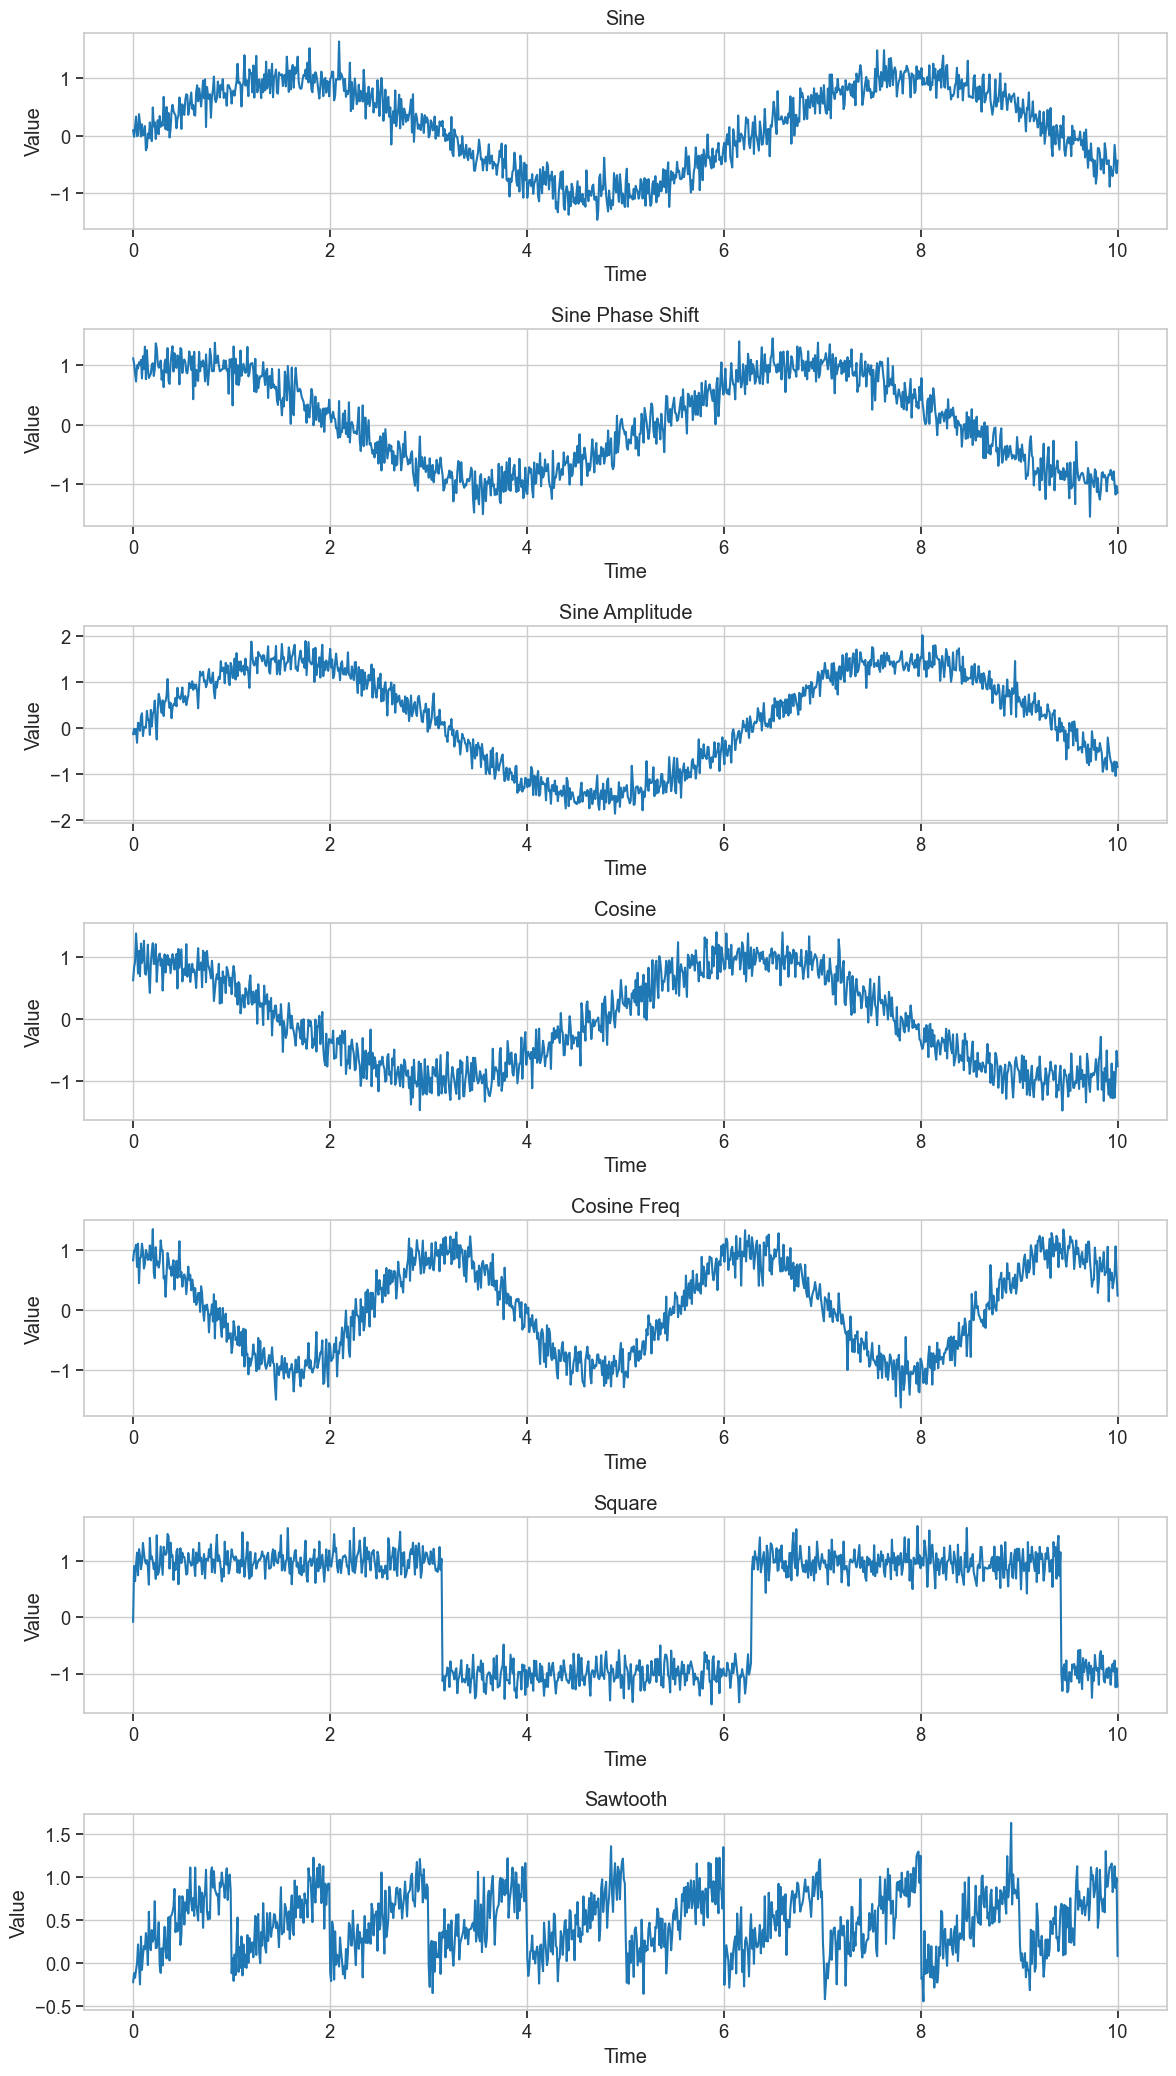

In [5]:
np.random.seed(42)

# Time vector
t = np.linspace(0, 10, 1000)

# Create a variety of time series for testing
signals = {
    "sine": np.sin(t) + 0.2 * np.random.randn(len(t)),
    "sine_phase_shift": np.sin(t + 1) + 0.2 * np.random.randn(len(t)),
    "sine_amplitude": 1.5 * np.sin(t) + 0.2 * np.random.randn(len(t)),
    "cosine": np.cos(t) + 0.2 * np.random.randn(len(t)),
    "cosine_freq": np.cos(2*t) + 0.2 * np.random.randn(len(t)),
    "square": np.sign(np.sin(t)) + 0.2 * np.random.randn(len(t)),
    "sawtooth": (t % 1) + 0.2 * np.random.randn(len(t))
}

# Plot all signals
fig, axes = plt.subplots(len(signals), 1, figsize=(12, 3*len(signals)))
for i, (name, signal) in enumerate(signals.items()):
    axes[i].plot(t, signal)
    axes[i].set_title(f"{name.replace('_', ' ').title()}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Value")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

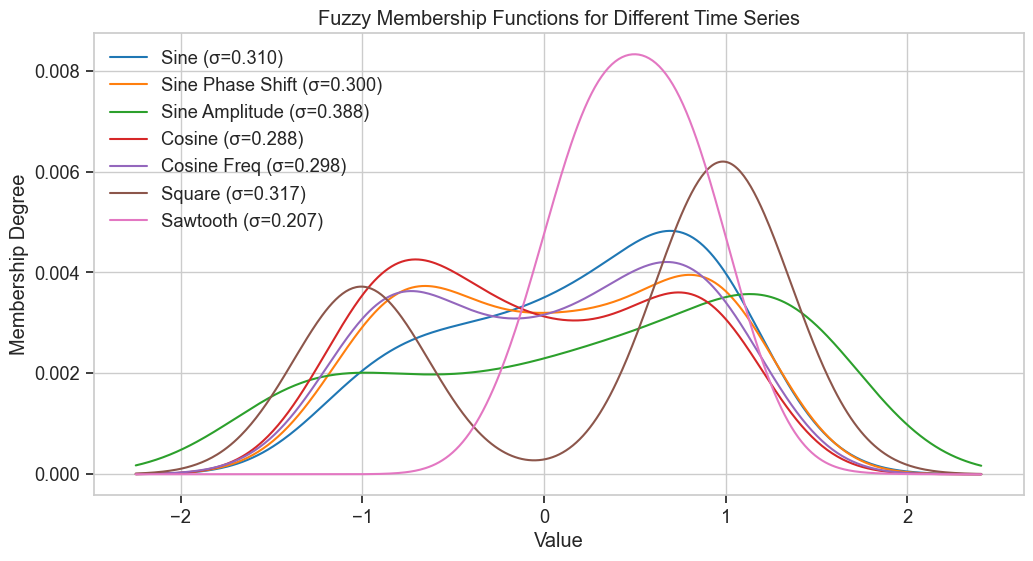

In [6]:
# Find common domain for all signals
all_values = np.concatenate(list(signals.values()))
x_min = np.min(all_values)
x_max = np.max(all_values)
x_range = x_max - x_min
x_values = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 500)

# Compute membership functions for all signals
membership_functions = {}
sigma_values = {}

for name, signal in signals.items():
    _, mu, sigma = compute_membership_function(signal, x_values, sigma='r0.1')
    membership_functions[name] = mu
    sigma_values[name] = sigma

# Plot membership functions
plt.figure(figsize=(12, 6))
for name, mu in membership_functions.items():
    plt.plot(x_values, mu, label=f"{name.replace('_', ' ').title()} (σ={sigma_values[name]:.3f})")

plt.xlabel("Value")
plt.ylabel("Membership Degree")
plt.title("Fuzzy Membership Functions for Different Time Series")
plt.legend()
plt.grid(True)
plt.show()

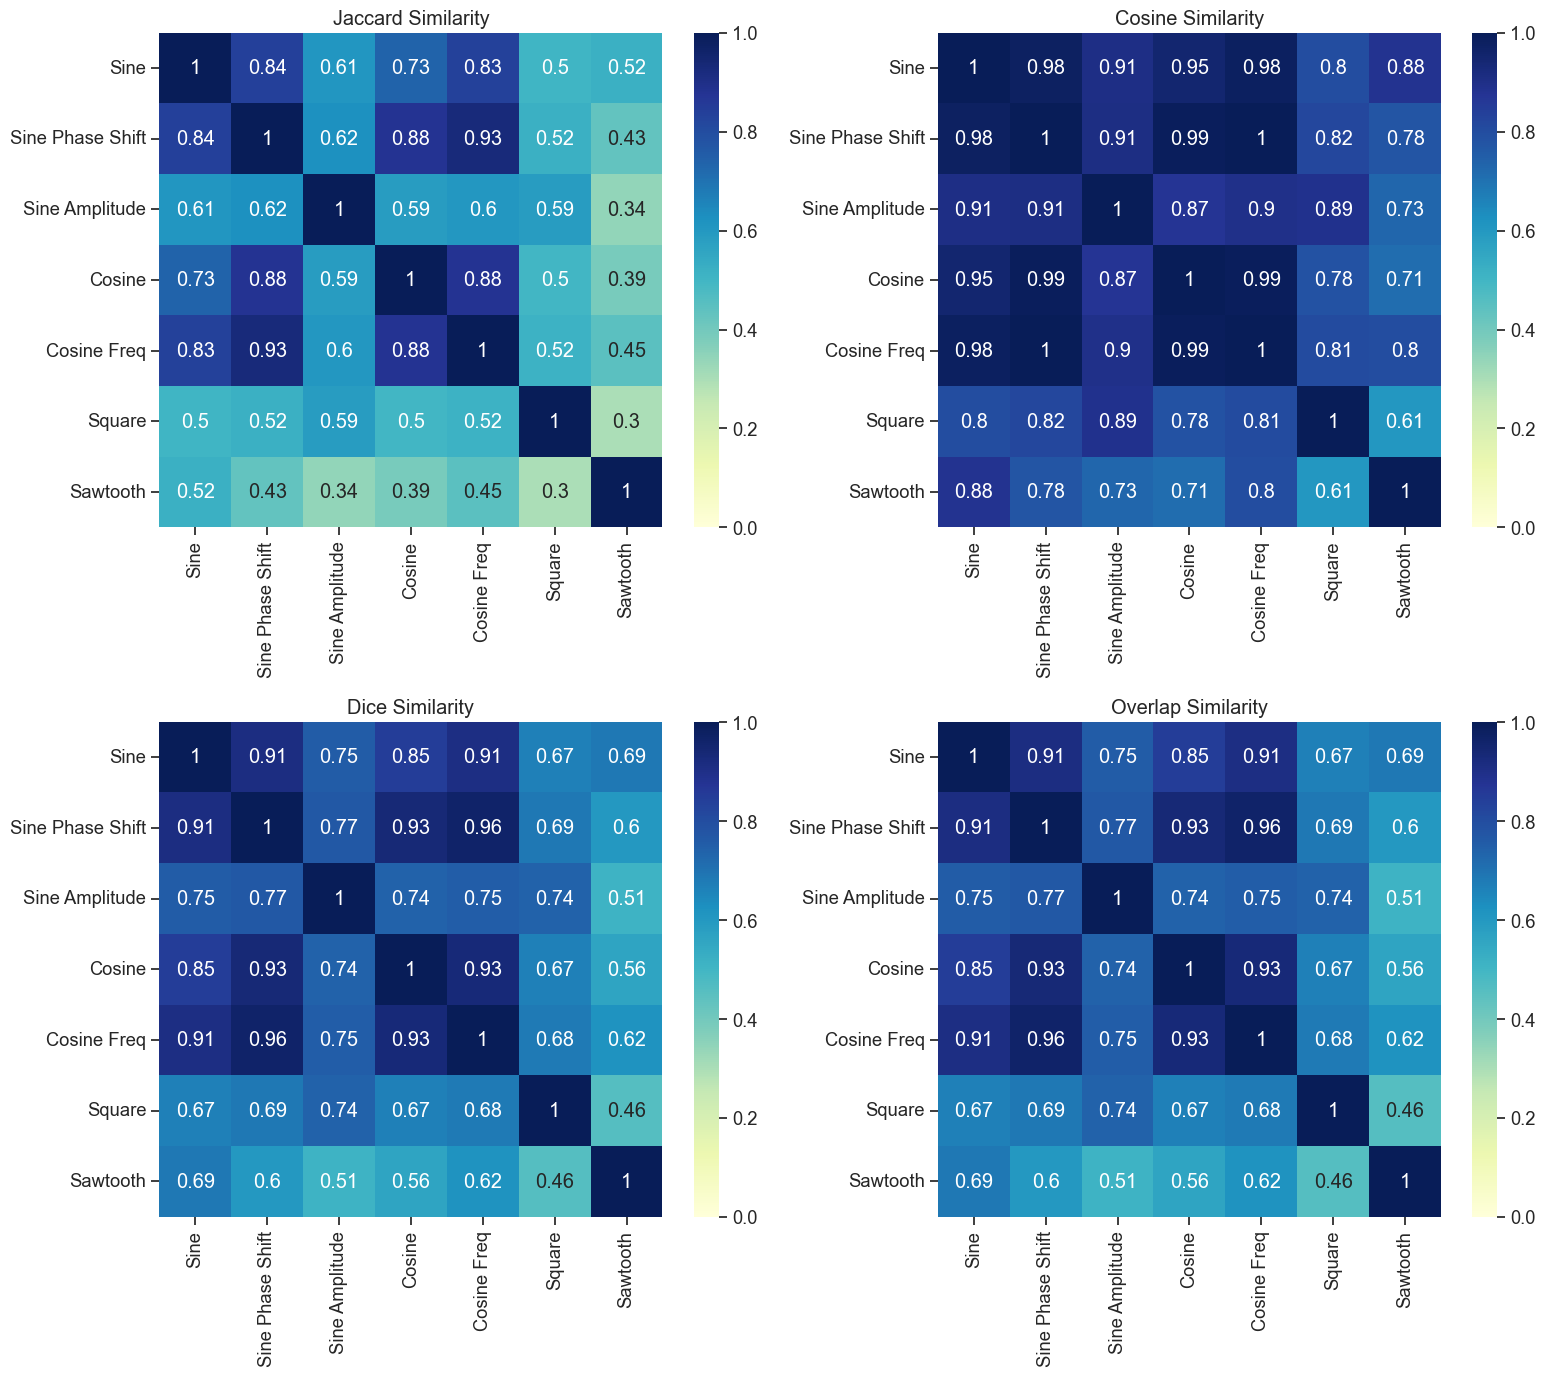

In [7]:
# List of similarity metrics to apply
metrics = {
    "Jaccard": similarity_jaccard,
    "Cosine": similarity_cosine,
    "Dice": similarity_dice,
    "Overlap": similarity_overlap_coefficient
}

# Compute similarity matrices
similarity_matrices = {}

for metric_name, metric_func in metrics.items():
    matrix = np.zeros((len(signals), len(signals)))
    for i, (name1, mu1) in enumerate(membership_functions.items()):
        for j, (name2, mu2) in enumerate(membership_functions.items()):
            matrix[i, j] = metric_func(mu1, mu2)
    similarity_matrices[metric_name] = matrix
    
# Plot heatmaps of similarity matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

signal_names = list(signals.keys())
display_names = [name.replace('_', ' ').title() for name in signal_names]

for i, (metric_name, matrix) in enumerate(similarity_matrices.items()):
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, 
                ax=axes[i], xticklabels=display_names, yticklabels=display_names)
    axes[i].set_title(f"{metric_name} Similarity")
    
plt.tight_layout()
plt.show()

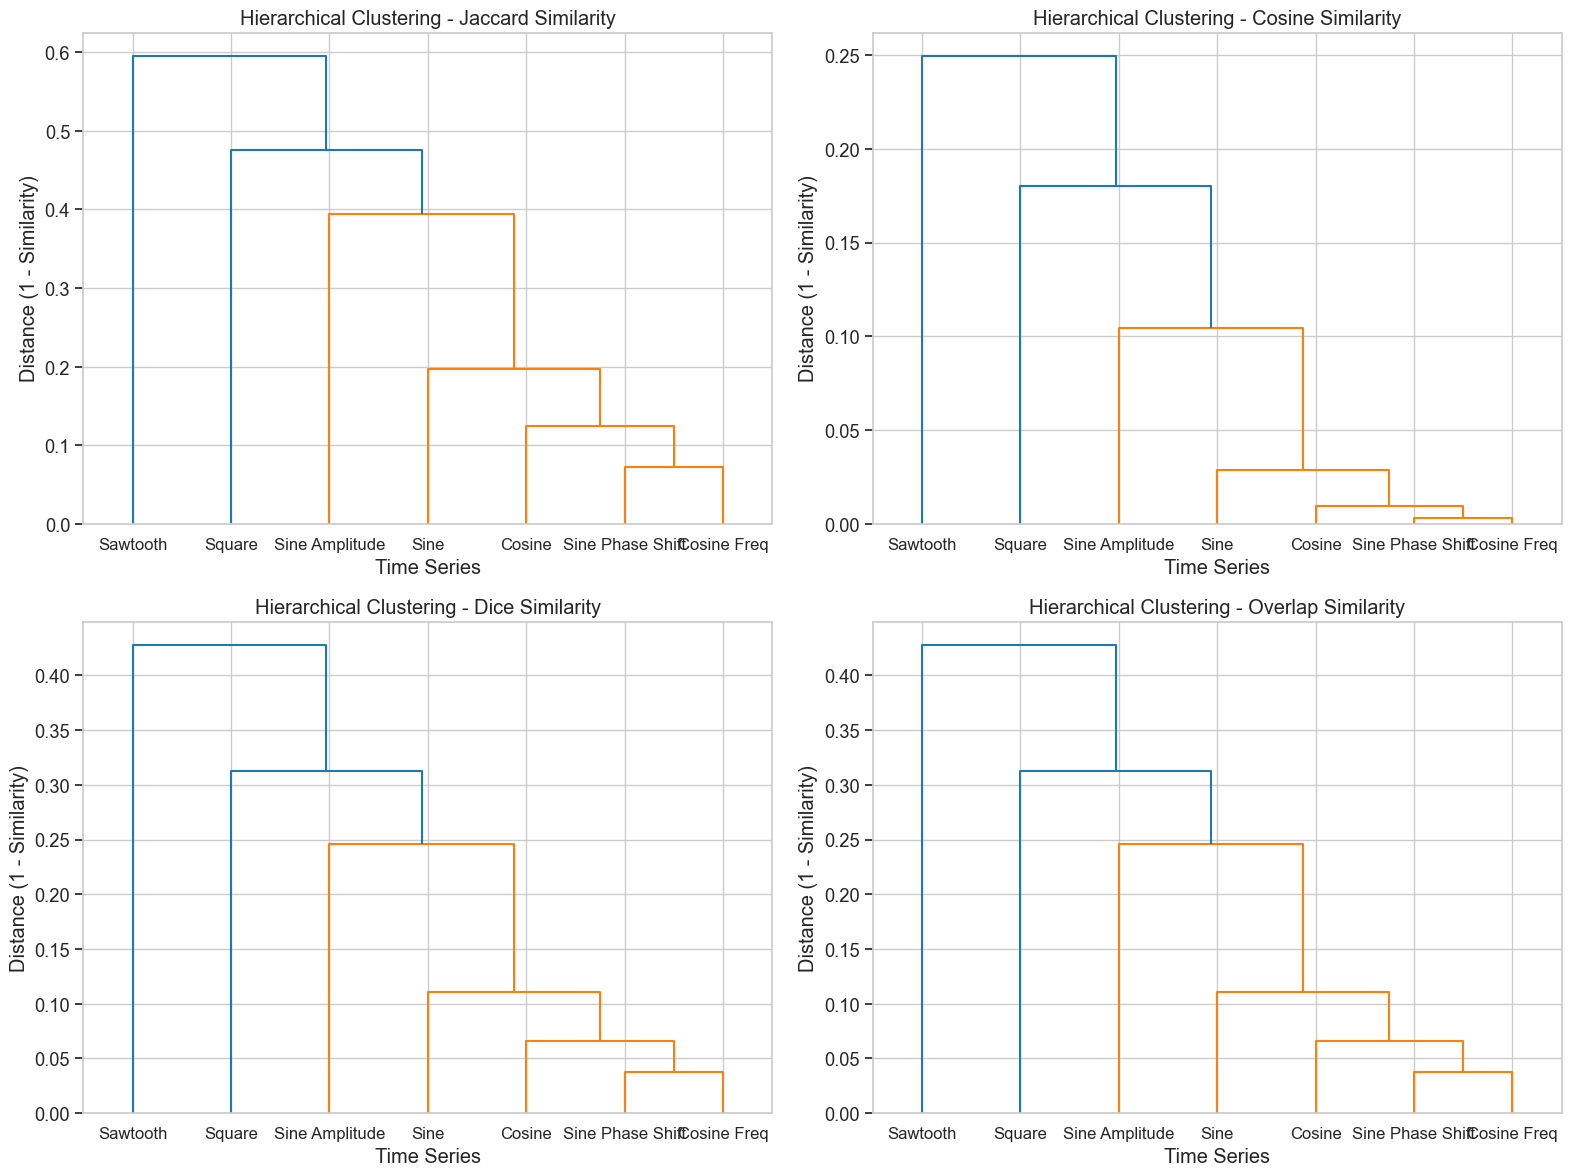

In [9]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Convert similarity to distance (1-similarity) for clustering
# Ensure diagonal is exactly zero (required for hierarchical clustering)
distance_matrices = {}
for metric_name, sim_matrix in similarity_matrices.items():
    dist_matrix = 1 - sim_matrix
    np.fill_diagonal(dist_matrix, 0)  # Ensure diagonal is exactly zero
    distance_matrices[metric_name] = dist_matrix
    
# Perform hierarchical clustering for each distance metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (metric_name, dist_matrix) in enumerate(distance_matrices.items()):
    # Convert to condensed form for linkage
    # The squareform function will raise an error if diagonal is not zero
    condensed_dist = squareform(dist_matrix)
    
    # Perform hierarchical clustering
    Z = hierarchy.linkage(condensed_dist, method='average')
    
    # Plot dendrogram
    hierarchy.dendrogram(Z, labels=display_names, ax=axes[i])
    axes[i].set_title(f"Hierarchical Clustering - {metric_name} Similarity")
    axes[i].set_xlabel("Time Series")
    axes[i].set_ylabel("Distance (1 - Similarity)")
    
plt.tight_layout()
plt.show()

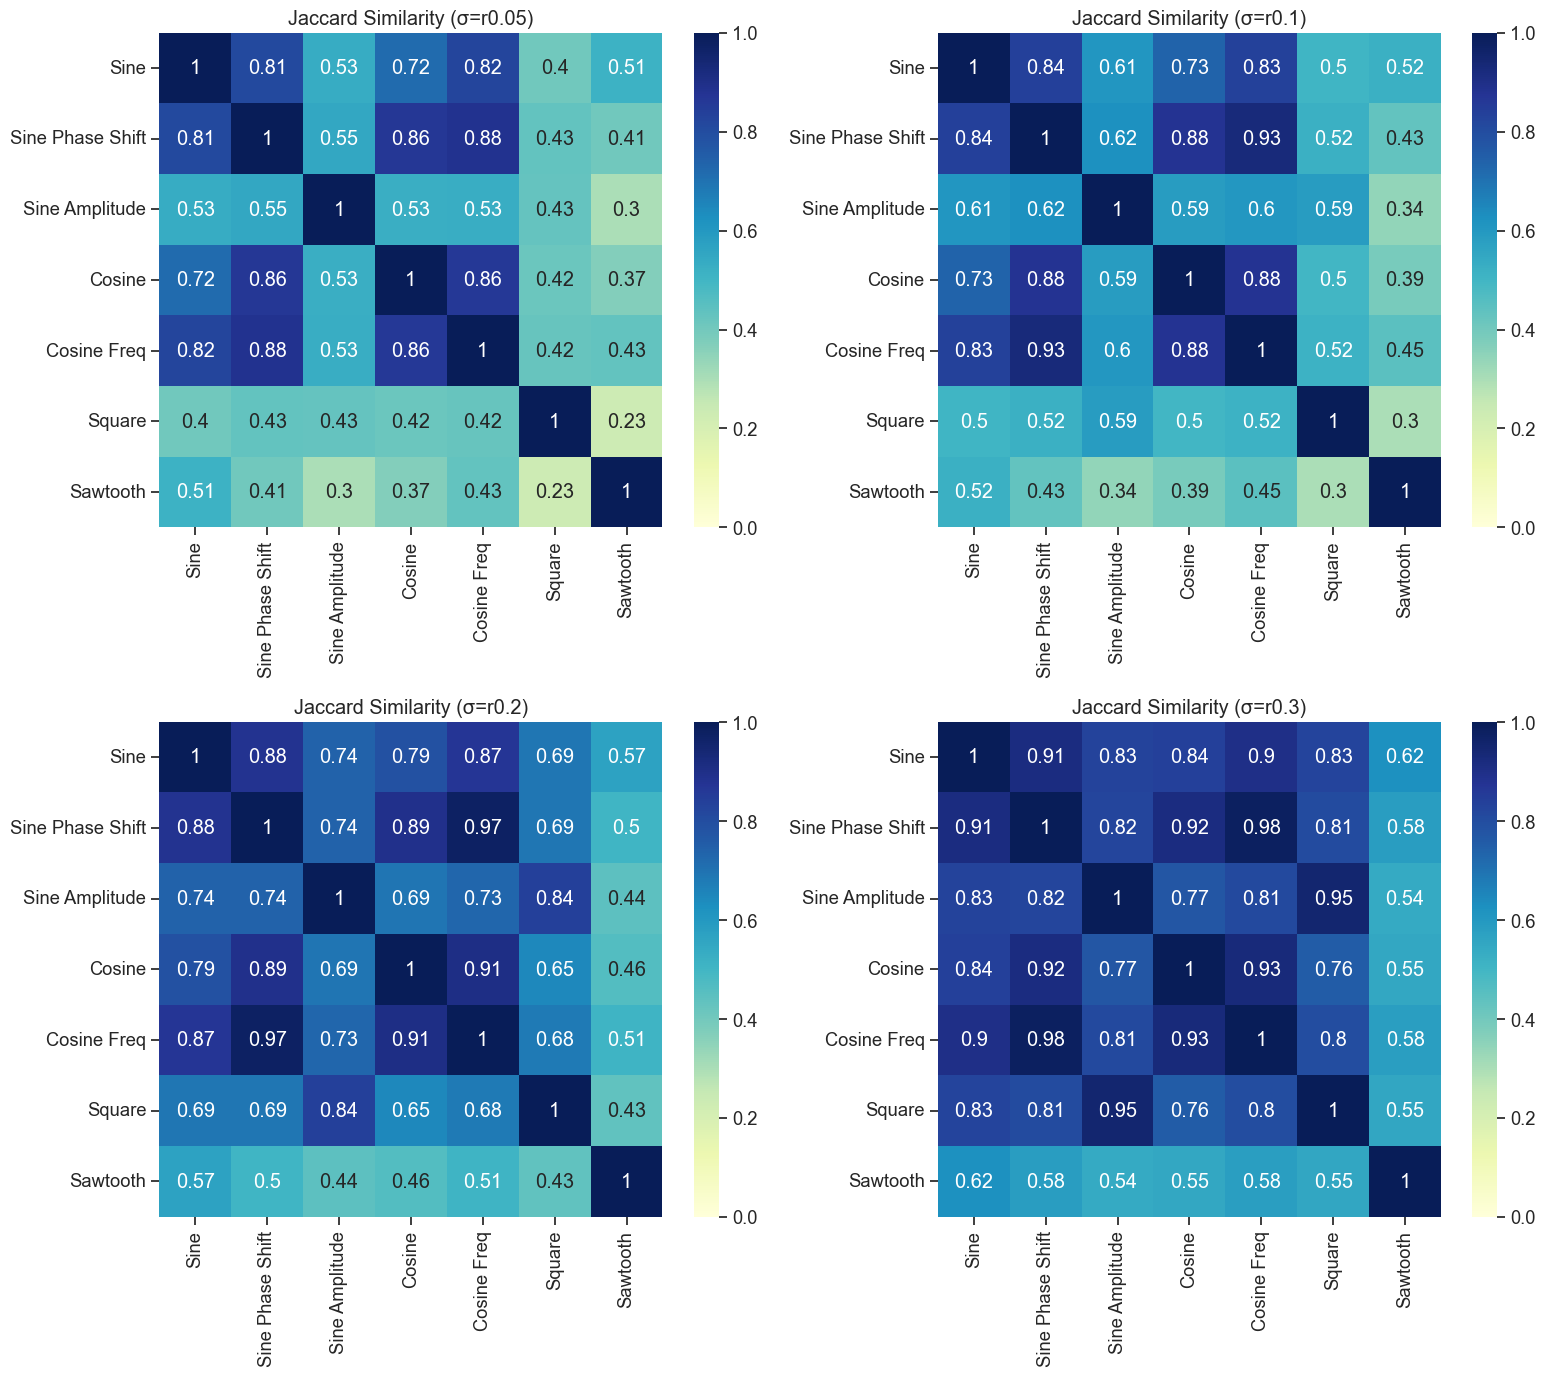

In [10]:
# Test different sigma values
sigma_options = ['r0.05', 'r0.1', 'r0.2', 'r0.3']

# Compute jaccard similarity matrices for different sigma values
jaccard_matrices = {}

for sigma in sigma_options:
    # Compute membership functions with this sigma
    temp_mu = {}
    for name, signal in signals.items():
        _, mu, _ = compute_membership_function(signal, x_values, sigma=sigma)
        temp_mu[name] = mu
    
    # Compute similarity matrix
    matrix = np.zeros((len(signals), len(signals)))
    for i, (name1, mu1) in enumerate(temp_mu.items()):
        for j, (name2, mu2) in enumerate(temp_mu.items()):
            matrix[i, j] = similarity_jaccard(mu1, mu2)
    
    jaccard_matrices[sigma] = matrix

# Plot heatmaps for different sigma values
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for i, (sigma, matrix) in enumerate(jaccard_matrices.items()):
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, 
                ax=axes[i], xticklabels=display_names, yticklabels=display_names)
    axes[i].set_title(f"Jaccard Similarity (σ={sigma})")
    
plt.tight_layout()
plt.show()

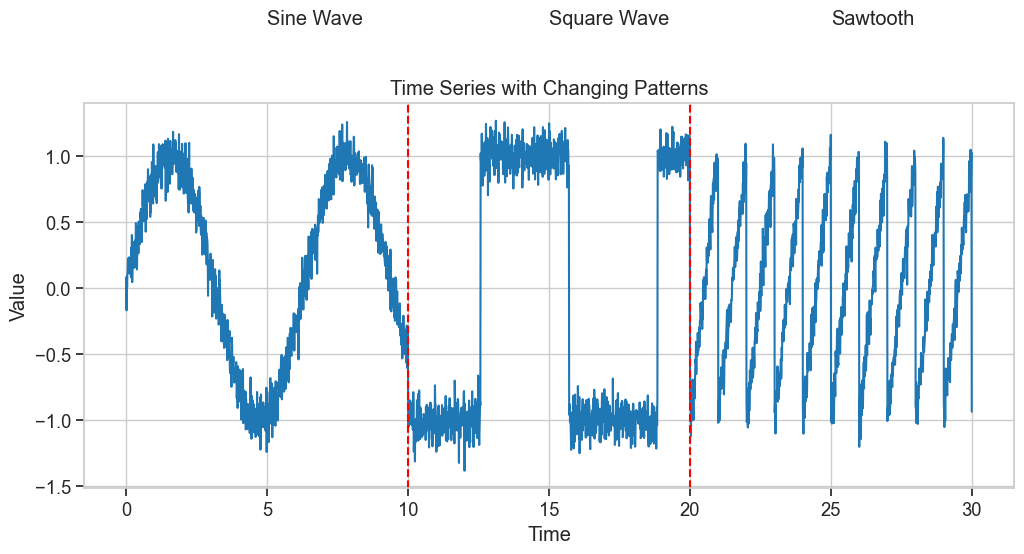

In [11]:
# Create a signal with changing patterns
# - First third: sine wave
# - Middle third: square wave
# - Last third: sawtooth

t_long = np.linspace(0, 30, 3000)
changing_signal = np.zeros_like(t_long)

# First segment: sine wave
changing_signal[:1000] = np.sin(t_long[:1000]) + 0.1 * np.random.randn(1000)

# Second segment: square wave
changing_signal[1000:2000] = np.sign(np.sin(t_long[1000:2000])) + 0.1 * np.random.randn(1000)

# Third segment: sawtooth
changing_signal[2000:] = (t_long[2000:] % 1) * 2 - 1 + 0.1 * np.random.randn(1000)

# Plot the changing signal
plt.figure(figsize=(12, 5))
plt.plot(t_long, changing_signal)
plt.axvline(x=t_long[1000], color='r', linestyle='--')
plt.axvline(x=t_long[2000], color='r', linestyle='--')
plt.text(t_long[500], 2, "Sine Wave")
plt.text(t_long[1500], 2, "Square Wave")
plt.text(t_long[2500], 2, "Sawtooth")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series with Changing Patterns")
plt.grid(True)
plt.show()

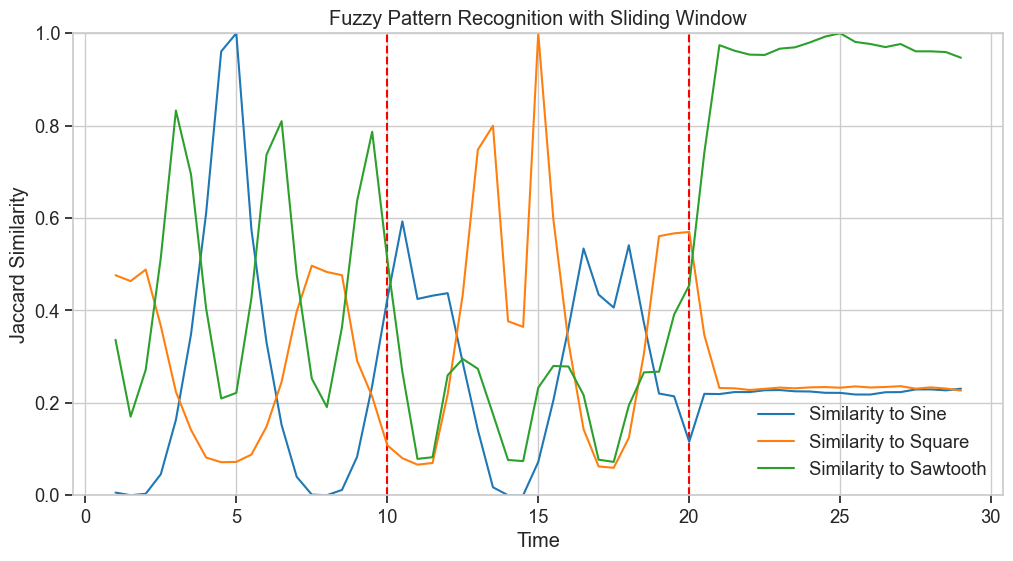

In [12]:
# Define window parameters
window_size = 600
step_size = 50

# Reference segments (one for each pattern)
reference_segments = {
    "sine": changing_signal[200:800],        # Middle of first segment
    "square": changing_signal[1200:1800],    # Middle of second segment
    "sawtooth": changing_signal[2200:2800]   # Middle of third segment
}

# Compute similarity over time using sliding window
window_centers = []
similarities = {ref_name: [] for ref_name in reference_segments.keys()}

# Find x_values range for all segments
all_data = np.concatenate([changing_signal] + list(reference_segments.values()))
x_min = np.min(all_data)
x_max = np.max(all_data)
x_range = x_max - x_min
x_values = np.linspace(x_min - 0.1*x_range, x_max + 0.1*x_range, 500)

# Precompute membership functions for reference segments
ref_memberships = {}
for ref_name, ref_segment in reference_segments.items():
    _, mu, _ = compute_membership_function(ref_segment, x_values, sigma='r0.1')
    ref_memberships[ref_name] = mu

# Sliding window analysis
for i in range(0, len(changing_signal) - window_size + 1, step_size):
    window = changing_signal[i:i+window_size]
    center = i + window_size // 2
    window_centers.append(t_long[center])
    
    # Compute membership function for current window
    _, window_mu, _ = compute_membership_function(window, x_values, sigma='r0.1')
    
    # Compare with reference segments
    for ref_name, ref_mu in ref_memberships.items():
        sim = similarity_jaccard(window_mu, ref_mu)
        similarities[ref_name].append(sim)

# Plot similarity over time
plt.figure(figsize=(12, 6))

# Plot boundaries between different patterns
plt.axvline(x=t_long[1000], color='r', linestyle='--')
plt.axvline(x=t_long[2000], color='r', linestyle='--')

# Plot similarity curves
for ref_name, sim_values in similarities.items():
    plt.plot(window_centers, sim_values, label=f"Similarity to {ref_name.capitalize()}")

plt.xlabel("Time")
plt.ylabel("Jaccard Similarity")
plt.title("Fuzzy Pattern Recognition with Sliding Window")
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.show()